# CSc 74020 Machine Learning Week 3: 

In [1]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

     |████████████████████████████████| 109 kB 23.2 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [44]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from scipy import stats
import random

import matplotlib.pylab as plt

%pylab inline
#%pylab --no-import-all

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
start_date=datetime.datetime(2013,1,1)
end_date=datetime.datetime(2020,12,31)

stock_list=['AAPL','FB','IBM','PG','VXX','INTC','GM']
stock_list

['AAPL', 'FB', 'IBM', 'PG', 'VXX', 'INTC', 'GM']

In [4]:
#download the data and calculate returns
df_temp=web.get_data_yahoo('SPY', start_date, end_date)
df_temp['SPY']=(df_temp['Adj Close']-df_temp['Adj Close'].shift(1))/df_temp['Adj Close'].shift(1)
df_temp=df_temp[1:]
df=df_temp[['SPY']]

df.head()

,SPY
Date,
2013-01-03,-0.002259
2013-01-04,0.004392
2013-01-07,-0.002733
2013-01-08,-0.002877
2013-01-09,0.002541


In [5]:
for stock in stock_list:
    print(stock)
    df_temp=web.get_data_yahoo(stock, start_date, end_date)
    df_temp[stock]=(df_temp['Adj Close']-df_temp['Adj Close'].shift(1))/df_temp['Adj Close'].shift(1)
    df_temp=df_temp[1:]
    df_temp=df_temp[[stock]]
    df=df.join(df_temp)
    
df.head() 

AAPL
FB
IBM
PG
VXX
INTC
GM


,SPY,AAPL,FB,IBM,PG,VXX,INTC,GM
Date,,,,,,,,
2013-01-03,-0.002259,-0.012622,-0.008214,-0.005501,-0.006341,NaN,-0.002806,0.023687
2013-01-04,0.004392,-0.027855,0.035650,-0.006555,0.002030,NaN,-0.007505,0.001341
2013-01-07,-0.002733,-0.005882,0.022949,-0.004382,-0.006802,NaN,0.004253,-0.006698
2013-01-08,-0.002877,0.002691,-0.012237,-0.001398,-0.001603,NaN,-0.007529,-0.009778
2013-01-09,0.002541,-0.015629,0.052650,-0.002852,0.005401,NaN,0.017070,0.020429


Let's fit the regular CAPM model for PG

$$ Return_{PG}(t)=\alpha + \beta * Return_{SPY}(t)+\epsilon$$

In [7]:
slope, intercept, r_value, pval, std_err = stats.linregress(df['SPY'],df['FB'])
print(slope, intercept, r_value, pval,std_err)
slope, intercept, r_value, pval, std_err = stats.linregress(df['SPY'],df['PG'])
print(slope, intercept, r_value, pval,std_err)
slope, intercept, r_value, pval, std_err = stats.linregress(df['SPY'],df['GM'])
print(slope, intercept, r_value, pval,std_err)

1.120798430152617 0.0006908055204819532 0.546703388095833 2.377184540528797e-157 0.038269828443106065
0.6462316920266246 0.0001443203181690339 0.594859368559098 4.628375938602001e-193 0.019468121852451687
1.198619459912554 -0.000211556565789061 0.6295201447927006 9.120373102987592e-223 0.03298145948005646


In [8]:
pred=intercept+slope*df['SPY']
err=df['PG']-pred
sigma_2=err.T.dot(err)/len(err)
print(sigma_2)

0.0001196548443436076


Now let's go through some basic bayesian theory,  Bayes' Theorem $$p(B|A)=\frac{p(A|B)p(B)}{p(A)}$$ Or expressed as distributions $$f(\theta|data)=\frac{f(data|\theta)f(\theta)}{f(data)}$$ In other words, the posterior distribution is equal to the sampling density times the prior distribution divided by the marginal probability for the data.  The denominator is actually $$f(data)=\int f(data|\theta)d\theta$$ which is a normailizing constant to make the posterior proper. $$f(data|\theta)$$ is proportional to the likelihood function.  In other words, $$Posterior \varpropto Likelihood \times Prior$$ A conjugate prior for the likelihood, is the prior distribution that a given likelihood function will produce a posterior in the same distribution family as the prior. 

Sometimes multivariate posterior distributions may not have a known form or may be very difficulat to sample from.  In these cases MCMC sampling techniques such as Gibbs and Metropolis-Hastings can be used.  




Let's determine the conjugate prior to fit CAPM (or a simple linear regression).  

We first must write out the likelihood function.   $$ L(X,Y|\beta,\sigma)=\prod_{i}\frac{1}{\sqrt{2\pi\sigma^2}}exp(-\frac{(y_i-X_i\beta )^2}{2\sigma^2})= (\frac{1}{\sqrt{2\pi\sigma^2}})^n exp(-\frac{\sum_i(y_i-X_i\beta )^2}{2\sigma^2})$$ $$=(\frac{1}{\sqrt{2\pi\sigma^2}})^n exp(-\frac{(Y-X\beta)^T(Y-X\beta)}{2\sigma^2})$$

To find the conjugate prior we want the prior to have a similar functional form with respect to $\beta$ and $\sigma$ so that it combines well.  In our case,the above likelihood function can be written to be normal in $\beta-\hat\beta$.  Clearly, $$(Y-X\beta)^T(Y-X\beta)=(Y-X\hat\beta+X\hat\beta-X\beta)^T(Y-X\hat\beta+X\hat\beta-X\beta)$$ $$=(Y-X\hat\beta)^T(Y-X\hat\beta)+(Y-X\hat\beta)^T(X\hat\beta-X\beta)+(X\hat\beta-X\beta)^T(Y-X\hat\beta)+(X\hat\beta-X\beta)^T(X\hat\beta-X\beta)$$ and since $$\hat\beta=(X^TX)^{-1}X^TY$$ the middle terms are $=0$ and therefore $$=(Y-X\hat\beta)^T(Y-X\hat\beta)+(X\hat\beta-X\beta)^T(X\hat\beta-X\beta)$$ $$=(Y-X\hat\beta)^T(Y-X\hat\beta)+(\hat\beta-\beta)^T(X^T X)(\hat\beta-\beta)$$  Substituting this in to the above equation gives

$$=(\frac{1}{\sqrt{2\pi\sigma^2}})^n exp(-\frac{(Y-X\hat\beta)^T(Y-X\hat\beta)}{2\sigma^2})exp(-\frac{(\hat\beta-\beta)^TX^T X(\hat\beta-\beta)}{2\sigma^2})$$


Clearly this is maximized when $\beta=\hat\beta$, but the purpose of this is to write the likelihood in a way to figure out a conjugate prior. Let $\nu s^2=(Y-X\hat\beta)^T(Y-X\hat\beta)$, $\nu=n-k$ where $k$ is the number of regression coefficients.  Then, we can re-write as
\begin{equation}
L(X,Y|\beta,\sigma)\varpropto(\frac{1}{\sigma^2})^{\nu/2} exp(-\frac{\nu s^2}{2\sigma^2})(\frac{1}{\sigma^2})^{-(n-\nu)/2}exp(-\frac{(\beta-\hat\beta)^TX^T X(\beta-\hat\beta)}{2\sigma^2})
\end{equation}
Notice this looks like an inverse-gamma pdf for $\sigma^2$ times a normal pdf for $\beta$ conditioned on $\sigma^2$.  This implies that if the prior distribution is the same the functional form in the posterior should be preserved. 

Define
$$p(\sigma^2)\varpropto (\sigma^2)^{-\nu_0/2-1}exp(-\frac{\nu_0 s_{0}^2}{2\sigma^2})$$

which is the Inverse-gamma, $IG(\alpha_0,\beta_0)$ with $\alpha_0=\nu_0/2$ and $\beta_0=\frac{1}{2}\nu_0 s_{0}^2$.  Relating this to the above likelihood one can see that $\nu_0$ and $s_0^2$ will correspond to prior values for $\nu$ and $s^2$ respectively.  Further, define

$$p(\beta|\sigma^2)\varpropto (\sigma^2)^{-k/2} exp(-\frac{1}{2\sigma^2}(\beta-\mu_0)^T \Lambda_0(\beta-\mu_0))$$

which is a condition prior distribution written as $\beta|\sigma^2 \sim N(\mu_0,\sigma^2\Lambda_0^{-1})$.  For our CAPM problem, $\Lambda_o=n\times Cov(X)$ so for larger $n$ the tighter the distribution for $\beta$ around $\mu_0$ implied by $\Lambda_0^{-1}$.  The reason we use $Cov(X)$ is to be able to interpret $n$ as a relative number of observations we are putting on the prior mean for $\beta$ vs. MLE $\beta$.

Combining the likelihood and the prior for $\beta$ we get the exponential term as

$$p(\beta|\sigma^2,X,Y)\varpropto exp(-\frac{1}{2\sigma^2}((\beta-\mu_0)^T \Lambda_0(\beta-\mu_0) +(Y-X\beta)^T(Y-X\beta))$$
$$=exp(-\frac{1}{2\sigma^2}((\beta^T\Lambda_0\beta-\mu_0^T\Lambda_0\beta)-(\beta^T\Lambda_0\mu_0-\mu_0^T\Lambda_0\mu_0)  +(Y^TY-Y^TX\beta)-(\beta^TX^TY-\beta^TX^TX\beta))$$
$$=exp(-\frac{1}{2\sigma^2}((\beta^T\Lambda_0\beta-\beta^T\Lambda_0\mu_0)-(\beta^T\Lambda_0\mu_0-\mu_0^T\Lambda_0\mu_0)  +(Y^TY-\beta^T(X^TX)\hat\beta)-(\beta^T(X^TX)\hat\beta-\beta^TX^TX\beta))$$
$$=exp(-\frac{1}{2\sigma^2}((\beta^T\Lambda_0\beta-\beta^T\Lambda_0\mu_0)-(\beta^T\Lambda_0\mu_0)  -\beta^T(X^TX)\hat\beta-(\beta^T(X^TX)\hat\beta-\beta^TX^TX\beta+\mu_0^T\Lambda_0\mu_0))exp(Y^TY)$$
Adding $\mu_0^T(X^TX)\hat\beta$
$$\varpropto exp(-\frac{1}{2\sigma^2}(\beta^T((\Lambda_0-X^TX)\beta-2(\Lambda_0\mu_0 +(X^TX)\hat\beta))+\mu_0^T(\Lambda_0\mu_0+(X^TX)\hat\beta))$$
Then adding $(-\mu_0+(\Lambda_0\mu_0+(X^TX)\hat\beta)(X^TX+\Lambda_0)^{-1}))(\Lambda_0\mu_0+(X^TX)\hat\beta)$ to complete the square gives
$$\varpropto exp(-\frac{1}{2\sigma^2}((\beta-(X^TX+\Lambda_0)^{-1}(\Lambda_0\mu_0 +(X^TX)\hat\beta))^T\times(\Lambda_0-X^TX)\times(\beta-(X^TX+\Lambda_0)^{-1}(\Lambda_0\mu_0 +(X^TX)\hat\beta)))$$
and that gives us the posterior mean
$$(X^TX+\Lambda_0)^{-1}(\Lambda_0\mu_0 +(X^TX)\hat\beta))$$

In [105]:
def bayes_capm(stock,benchmark,prior_mu,prior_n):
    """
    Function to calculate the Bayesian CAPM for a given stock and benchmark
    """
    N=len(benchmark)
    Lambda=np.identity(2)
    #create the design matrix
    X = np.ones((N,2))
    X[:,1] = benchmark
    XTX=X.T.dot(X)
    beta_hat=inv(XTX).dot(X.T).dot(stock) 
    post_beta=inv(XTX+(float(prior_n)/N)*XTX).dot(XTX.dot(beta_hat)+(float(prior_n)/N)*XTX.dot(prior_mu))
    return post_beta

In [10]:
#Prior beta of 1, n=100
bayes_capm(df['PG'],df['SPY'],1,1,[0,1],100)

array([1.37493435e-04, 6.62966238e-01])

In [11]:
#Prior beta of 1, n=100
bayes_capm(df['GM'],df['SPY'],1,1,[0,1],100)

array([-2.01549160e-04,  1.18922403e+00])

In [106]:
#function to test which n0 to use for prior
def test_n0(stock,n0_start,n0_end,n0_by):
    num_experiments=500
    NN=len(df[stock])
    n0_range=np.arange(n0_start,n0_end,n0_by)
    error_sums=np.zeros(len(n0_range))
    shuffle_list=np.arange(NN)
    test=int(.7*NN)
    #run num_experiments different expiriments to reduce variance
    for iter in range(num_experiments):
        random.shuffle(shuffle_list)
        for n0 in n0_range:    
            post_beta=bayes_capm(df[stock].iloc[shuffle_list[:test]],df['SPY'].iloc[shuffle_list[:test]],[0,1],n0)
            pred=post_beta[0]+post_beta[1]*df['SPY']
            err=df[stock]-pred
            err=err.iloc[shuffle_list[test:]]
            error_sums[int((n0-n0_start)/n0_by)]=error_sums[int((n0-n0_start)/n0_by)]+err.T.dot(err)
    error_sums=error_sums/num_experiments
    plt.plot(n0_range,error_sums) 

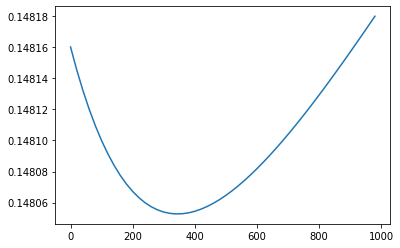

In [107]:
test_n0('GM',0,1000,20)

In [110]:
post_beta=bayes_capm(df[stock],df['SPY'],[0,1],350)
post_beta

array([-1.80235556e-04,  1.16921415e+00])

In [109]:
post_beta=bayes_capm(df[stock],df['SPY'],[0,1],4000)
post_beta

array([-7.08474981e-05,  1.06651517e+00])

**Question:** What's wrong with this approach? \\

**Answer:** Data Partitioning. We may want to partition based on time instead of random for hyperparameter tuning

In [111]:
df

,SPY,AAPL,FB,IBM,PG,VXX,INTC,GM
Date,,,,,,,,
2013-01-03,-0.002259,-0.012622,-0.008214,-0.005501,-0.006341,NaN,-0.002806,0.023687
2013-01-04,0.004392,-0.027855,0.035650,-0.006555,0.002030,NaN,-0.007505,0.001341
2013-01-07,-0.002733,-0.005882,0.022949,-0.004382,-0.006802,NaN,0.004253,-0.006698
2013-01-08,-0.002877,0.002691,-0.012237,-0.001398,-0.001603,NaN,-0.007529,-0.009778
2013-01-09,0.002541,-0.015629,0.052650,-0.002852,0.005401,NaN,0.017070,0.020429
...,...,...,...,...,...,...,...,...
2020-12-24,0.003890,0.007712,-0.002648,0.006376,0.010122,-0.028769,0.010737,-0.020495
2020-12-28,0.008591,0.035766,0.035901,0.001043,0.006971,-0.003554,0.000000,0.001924
2020-12-29,-0.001908,-0.013315,-0.000794,-0.008172,-0.001875,0.036266,0.049288,-0.002160


In [16]:
bayes_capm(df['GM'],df['SPY'],1,1,[0,1],300)

array([-1.84129180e-04,  1.17286931e+00])

Let's try a Ridge model.  Ridge penaized parameters for being different from zero, so in our case we must reformulate the problem.  The regular CAPM is $$r_t=\alpha+\beta b_t+\epsilon_t$$ where $r_t$ is the return of the stock and $b_t$ is the return of the benchmark.  Reformulate to 
$$(r_t-b_t)=\alpha+(\beta-1)b_t=\alpha+\tilde\beta b_t$$
so that stocks should not stray too far from the overall avaerage $\alpha=0$ and $\tilde\beta=0$.

So $\beta=\tilde\beta+1$

Again, you would want to optimize for alpha here

In [112]:
#function to test which n0 to use for prior
def test_alpha_ridge(stock,alpha_start,alpha_end,alpha_by):
    num_experiments=500
    NN=len(df[stock])
    alpha_range=np.linspace(alpha_start,alpha_end,int((alpha_end-alpha_start)/alpha_by))
    error_sums=np.zeros(len(alpha_range))
    betas=np.zeros(len(alpha_range))
    intercept=np.zeros(len(alpha_range))
    shuffle_list=np.arange(NN)
    test=int(.7*NN)
    #run num_experiments different expiriments to reduce variance
    for iter in range(num_experiments):
        random.shuffle(shuffle_list)
        for alpha in range(len(alpha_range)):    
            ridge_model = Ridge(alpha=alpha_range[alpha],max_iter=10000, tol=0.00001)
            #mutliplied by 100 to reduce floating point issues
            ridge_fit = ridge_model.fit(df[['SPY']].iloc[shuffle_list[:test]],(df[stock].iloc[shuffle_list[:test]]-df['SPY'].iloc[shuffle_list[:test]]))
            pred=(ridge_fit.intercept_)+(1+ridge_fit.coef_[0])*df['SPY']
            err=df[stock]-pred            
            err=err.iloc[shuffle_list[test:]]
            error_sums[alpha]=error_sums[alpha]+err.T.dot(err)
            betas[alpha]+=(1+ridge_fit.coef_[0])
            intercept[alpha]+=(ridge_fit.intercept_)
    error_sums=error_sums/num_experiments
    betas=betas/num_experiments
    intercept=intercept/num_experiments
    print(intercept)
    print(betas)
    plt.plot(alpha_range,error_sums) 
    return error_sums

[-0.00022473 -0.00022281 -0.00022096 -0.00021917 -0.00021744 -0.00021576
 -0.00021413 -0.00021254 -0.00021101 -0.00020952 -0.00020807 -0.00020666
 -0.00020529 -0.00020396 -0.00020266 -0.0002014  -0.00020017 -0.00019898
 -0.00019781]
[1.19306148 1.18992016 1.18687985 1.18393574 1.18108331 1.17831833
 1.17563682 1.17303505 1.1705095  1.16805685 1.16567399 1.16335797
 1.16110601 1.15891547 1.15678387 1.15470886 1.15268821 1.1507198
 1.14880162]


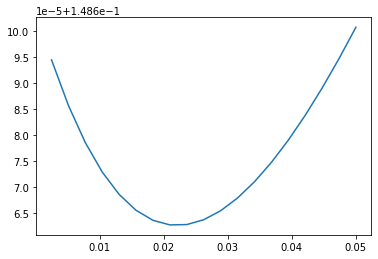

In [113]:
error_sums=test_alpha_ridge('GM',.0025,.05,.0025)

## What about Lasso regression?

In [129]:
#function to test which n0 to use for prior
def test_alpha(stock,alpha_start,alpha_end,alpha_by):
    num_experiments=500
    NN=len(df[stock])
    alpha_range=np.linspace(alpha_start,alpha_end,int((alpha_end-alpha_start)/alpha_by))
    error_sums=np.zeros(len(alpha_range))
    betas=np.zeros(len(alpha_range))
    intercept=np.zeros(len(alpha_range))
    shuffle_list=np.arange(NN)
    test=int(.7*NN)
    #run num_experiments different expiriments to reduce variance
    for iter in range(num_experiments):
        random.shuffle(shuffle_list)
        for alpha in range(len(alpha_range)):    
            lasso_model = Lasso(alpha=alpha_range[alpha],max_iter=10000, tol=0.0000001,selection='random')
            #multiply by 100 for floating point
            lasso_fit = lasso_model.fit(100.*df[['SPY']].iloc[shuffle_list[:test]],100.*(df[stock].iloc[shuffle_list[:test]]-df['SPY'].iloc[shuffle_list[:test]]))
            pred=(lasso_fit.intercept_/100.)+(1.+lasso_fit.coef_[0])*df['SPY']            
            err=df[stock]-pred            
            err=err.iloc[shuffle_list[test:]]
            error_sums[alpha]=error_sums[alpha]+err.T.dot(err)
            betas[alpha]+=(1+lasso_fit.coef_[0])
            intercept[alpha]+=(lasso_fit.intercept_/100.)
    error_sums=error_sums/num_experiments
    betas=betas/num_experiments
    intercept=intercept/num_experiments
    print(intercept)
    print(betas)
    plt.plot(alpha_range,error_sums) 
    return error_sums

[-0.00021246 -0.00021235 -0.00021224 -0.00021213 -0.00021202 -0.00021191
 -0.0002118  -0.00021169 -0.00021158 -0.00021147 -0.00021136 -0.00021125
 -0.00021114 -0.00021103 -0.00021092 -0.00021081 -0.0002107  -0.0002106
 -0.00021049 -0.00021038 -0.00021027 -0.00021016 -0.00021005 -0.00020994
 -0.00020983 -0.00020972 -0.00020961 -0.0002095  -0.00020939 -0.00020928
 -0.00020917 -0.00020906 -0.00020895 -0.00020884 -0.00020873 -0.00020862
 -0.00020851 -0.0002084  -0.00020829 -0.00020818 -0.00020807 -0.00020796
 -0.00020785 -0.00020775 -0.00020764 -0.00020753 -0.00020742 -0.00020731
 -0.0002072  -0.00020709 -0.00020698 -0.00020687 -0.00020676 -0.00020665
 -0.00020654 -0.00020643 -0.00020632 -0.00020621 -0.0002061  -0.00020599
 -0.00020588 -0.00020577 -0.00020566 -0.00020555 -0.00020544 -0.00020533
 -0.00020522 -0.00020511 -0.000205   -0.0002049  -0.00020479 -0.00020468
 -0.00020457 -0.00020446 -0.00020435 -0.00020424 -0.00020413 -0.00020402
 -0.00020391 -0.0002038  -0.00020369 -0.00020358 -0.

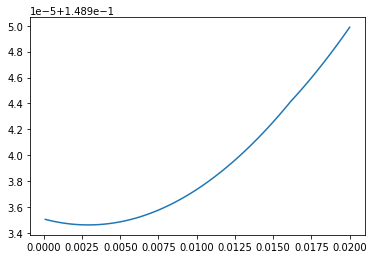

In [132]:
error_sums=test_alpha('GM',.0001,.02,.0002)